# HQCS Assignment 3 – Task 3: BONUS: QML + Classical Shadows

**Group:** 10  

**Members:** Marijana Petojevic, Vedad Hadzic, Sam de Vries

**Environment:** Google Colab T4 GPU


## Introduction

In this exercise, we study variational quantum classifiers (VQCs) and the effect that noise has on the training process.

We apply noise to a VQC to understand the effect that noise has on the following properties:
- accuracy
- loss
- convergence
- re-uploading

For this task, we have to understand that noise takes away the knowledge that we have about the working of the model. For that reason we have to estimate the outcome. This will be done using the classical shadow method which we already dived into in task 2.

To obtain the results, the code for task 1 is altered to fit this exercise. This is mainly done by:
- Applying `DepolarizongChannel` noise in the circuit
- Adding a second circuit that can be used for computing the classical shadows
- Changing the evaluation function to work with shadows



# Install & import dependencies
- Colab already has numpy, matplotlib, pandas

In [ ]:
!pip install pennylane pennylane-lightning


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 52.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 935.6/935.6 kB 38.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 67.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 68.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 79.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 13.0 MB/s eta 0:00:00


# Imports + reproducibility

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pennylane as qml

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix
import tqdm as tqdm

np.random.seed(42)

# Load datasets and test/train datasplit

The `load_dataset` function is responsible for reading and preprocessing the input data before training the quantum classifiers. First, the dataset is loaded from a CSV file using pandas. The two input features, `carol_singing` and `snowball_energy`, are extracted as the input matrix, while the target class is stored in the label vector.

Since the quantum circuits use angle encoding, the input features are rescaled to the interval
[−π,π]
[−π,π] using min–max normalization. This ensures that the rotation angles used in the quantum gates are well-scaled and helps stabilize training.

We also split the dataset into training and test sets using a 70/30 split. Stratified sampling is applied to preserve the class distribution in both subsets, and a fixed random seed is used to ensure reproducibility of the results.

In [ ]:
def load_dataset(path):
    df = pd.read_csv(path)

    X = df[["carol_singing", "snowball_energy"]].values
    y = df["label"].values

    scaler = MinMaxScaler(feature_range=(-np.pi, np.pi))
    X_scaled = scaler.fit_transform(X)

    return train_test_split(
        X_scaled, y,
        test_size=0.3,
        random_state=42,
        stratify=y
    )

## Classical shadows

The code below shows to computation of how many samples we would need to obtain a certain maximum error.

To compute this, code from the second task has been reused.

In our case, we only have one observable: ⟨Z0​⟩.



In [ ]:
M = 1                     # number of observables
delta = 0.01              # failure probability (99% confidence)
max_shadow_norm_sq = 3    # worst-case shadow norm
epsilons = [0.1, 0.05, 0.001, 0.005]

# logarithmic term
log_term = np.log(2 * M / delta)

# num of samples
required_samples = {}
for eps in epsilons:
    N = (2 * log_term / eps**2) * max_shadow_norm_sq
    required_samples[eps] = int(np.ceil(N))

print("Required number of samples for classical shadows:\n")
for eps, N in required_samples.items():
    print(f"ε = {eps:<6} → N ≥ {N:,}")

Required number of samples for classical shadows:

ε = 0.1    → N ≥ 3,179
ε = 0.05   → N ≥ 12,716
ε = 0.001  → N ≥ 31,789,905
ε = 0.005  → N ≥ 1,271,597


# Baseline VQC (NO re-uploading)

This is the `train_vqc_baseline` function from task 1. However, the changes made are:

1. `exp_circuit`: The circuit from `train_vqc_baseline` but with added noise.
2. `shadow_circuit`: An added circuit. This is the same circuit as `exp_circuit`, however it returns a classical shadow instead of an expected value.

In [ ]:
import pennylane as qml
from pennylane import numpy as pnp
import tqdm

def train_vqc_with_shadows(
    X_train, y_train,
    n_qubits=2,
    entangle=True,
    stepsize=0.1,
    epochs=50,
    p_noise=0.1
):


    # Create a quantum device with the specified number of qubits
    dev = qml.device("default.mixed", wires=n_qubits)

    # Encode classical input features into quantum rotations (angle encoding)
    def encode(x):
        for i in range(n_qubits):
            qml.RX(x[i], wires=i)

    # Single variational layer with trainable parameters
    def variational_layer(weights):
        # Apply parameterized rotations on each qubit
        for i in range(n_qubits):
            qml.RY(weights[i], wires=i)
        # Optionally apply entanglement between qubits, we set different entangöement strategies for each dataset when we train classifier
        if entangle:
            qml.CNOT(wires=[0, 1])
            qml.CNOT(wires=[1, 0])

   # Define the quantum circuit as a PennyLane QNode
    @qml.qnode(dev)
    def expval_circuit(x, weights):
        encode(x)
        variational_layer(weights)
        for w in range(n_qubits):
            qml.DepolarizingChannel(p_noise, wires=w)
        return qml.expval(qml.PauliZ(0))

    # Define the classical shadow quantum circuit as a PennyLane QNode
    @qml.qnode(dev)
    def shadow_circuit(x, weights):
        encode(x)
        variational_layer(weights)
        for w in range(n_qubits):
            qml.DepolarizingChannel(p_noise, wires=w)
        return qml.classical_shadow(wires=range(n_qubits))

    # Define the loss function (mean squared error)
    # Uses continuous circuit outputs for differentiability
    def loss(weights):
      preds = [expval_circuit(x, weights) for x in X_train]
      return pnp.mean((pnp.array(preds) - y_train) ** 2)

    def grad_norm(weights):
        grads = qml.grad(loss)(weights)
        return pnp.linalg.norm(grads)

    # Initialize trainable parameters with small random values
    weights = pnp.random.normal(0, 0.1, size=(n_qubits,), requires_grad=True)
    # Use Adam optimizer for training
    opt = qml.AdamOptimizer(stepsize=stepsize)

    # Store loss values for each training epoch
    losses = []
    grad_norms = []
    for _ in tqdm.tqdm(range(epochs)):
        weights, current_loss = opt.step_and_cost(loss, weights)
        losses.append(current_loss)
        grad_norms.append(grad_norm(weights))

    # Return trained parameters, loss history, gradient historey and shadow circuit
    return weights, losses, grad_norms, shadow_circuit


# Evaluate model

The `evaluate` function is used to assess the performance of a trained variational quantum classifier. It uses the `shadow_circuit` for evaluation. For each element of data **X**, it computes the classical shadow given an amount of samples. This classical shadow is subsequently used to compute the expected value for that input.

After iterating over all elements of the data set, the accuracy is computed using the true labels.


In [ ]:
def evaluate(circuit, weights, X, y, observable=0):
    preds = []
    for x in X:
        bits, recipes = qml.set_shots(circuit, shots=5000)(x, weights)
        shadow = qml.ClassicalShadow(bits, recipes)
        expval_z = shadow.expval([qml.PauliZ(observable)])
        # Threshold at 0 to get binary class label
        preds.append(int(expval_z > 0))

    # Accuracy and confusion matrix
    acc = accuracy_score(y, preds)
    cm = confusion_matrix(y, preds)

    return acc, cm

# BASELINE MODELS (NO RE-UPLOAD)

We now train classifiers on our datasets.

## Gluhweindorf (baseline)


Gluehweindorf for noise p = 0


100%|██████████| 50/50 [09:01<00:00, 10.82s/it]


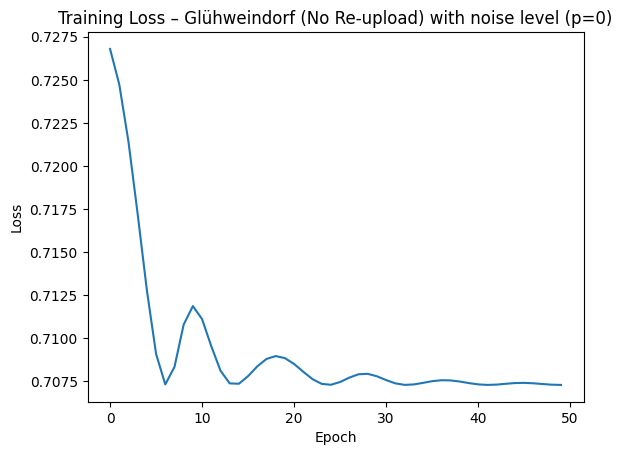

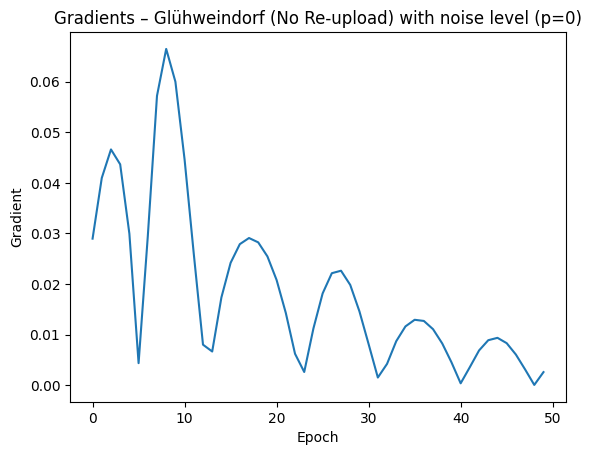

Train/Test accuracy: 0.7857142857142857 0.8266666666666667
Gluehweindorf for noise p = 0.1


100%|██████████| 50/50 [07:32<00:00,  9.05s/it]


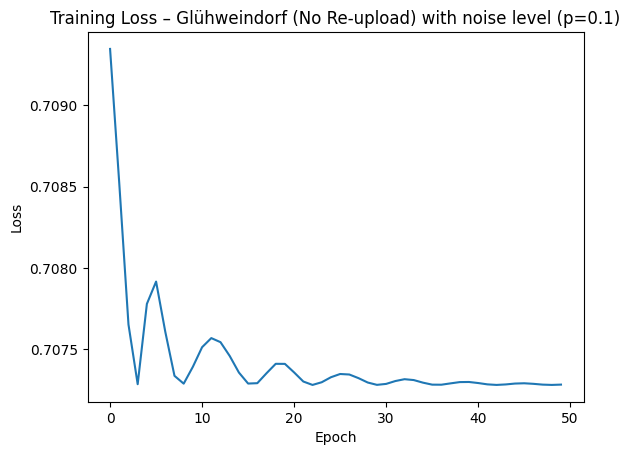

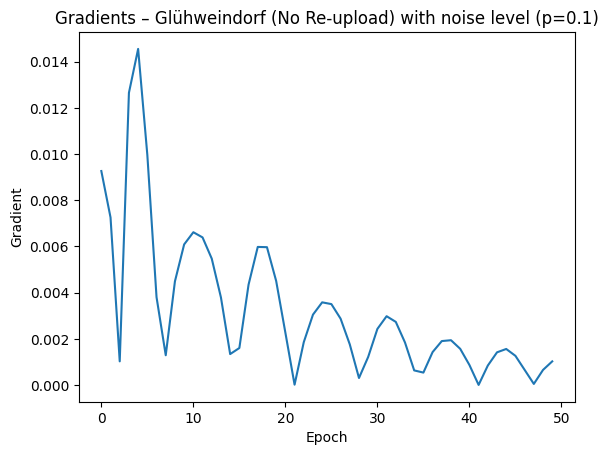

Train/Test accuracy: 0.7857142857142857 0.84
Gluehweindorf for noise p = 0.25


100%|██████████| 50/50 [07:00<00:00,  8.41s/it]


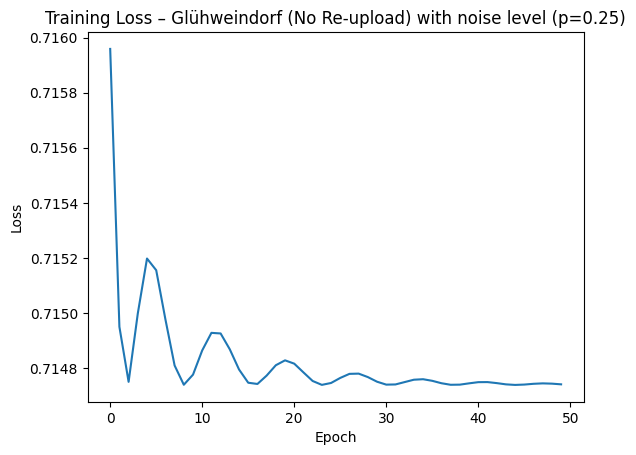

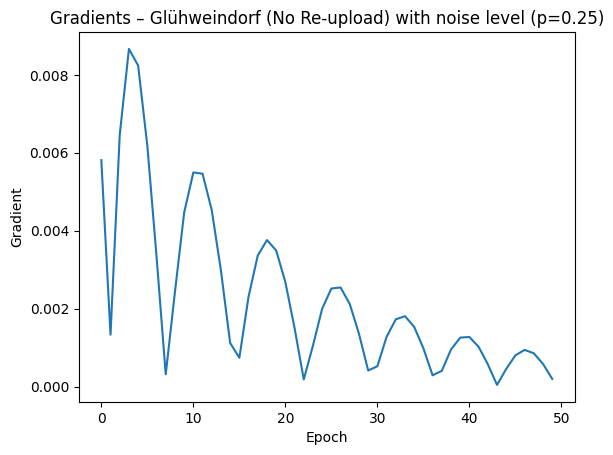

Train/Test accuracy: 0.7914285714285715 0.8333333333333334
Gluehweindorf for noise p = 0.5


100%|██████████| 50/50 [07:06<00:00,  8.53s/it]


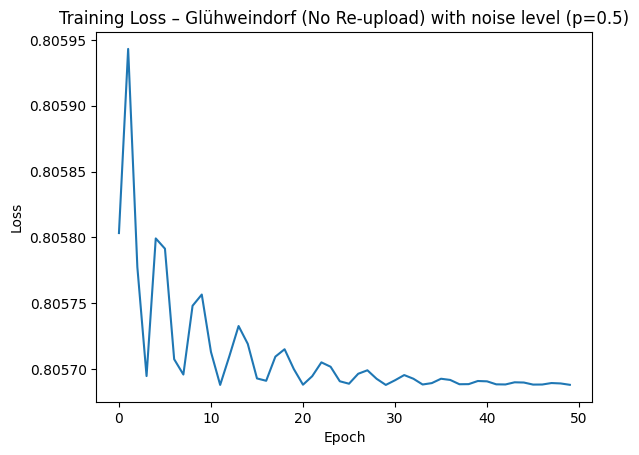

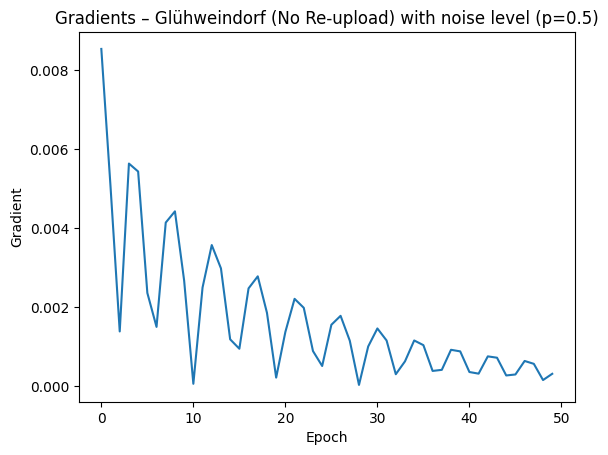

Train/Test accuracy: 0.7828571428571428 0.8266666666666667
Gluehweindorf for noise p = 0.75


100%|██████████| 50/50 [06:55<00:00,  8.32s/it]


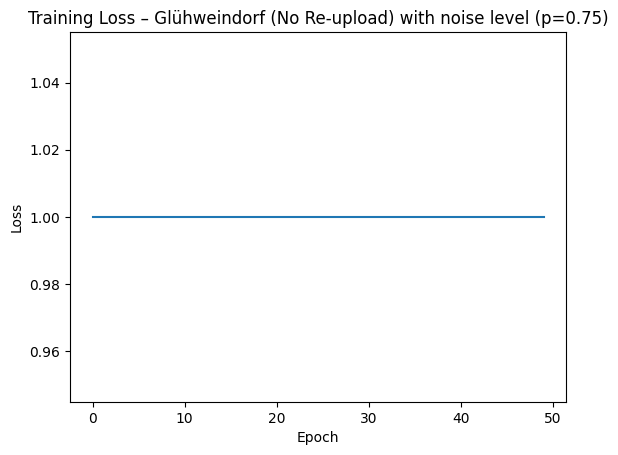

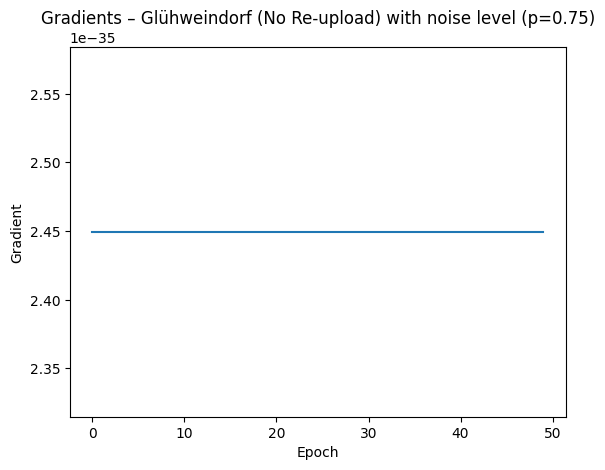

Train/Test accuracy: 0.48857142857142855 0.48
Gluehweindorf for noise p = 1


100%|██████████| 50/50 [07:25<00:00,  8.91s/it]


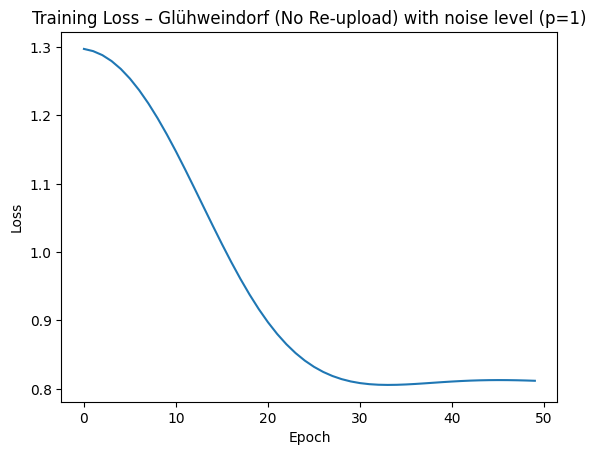

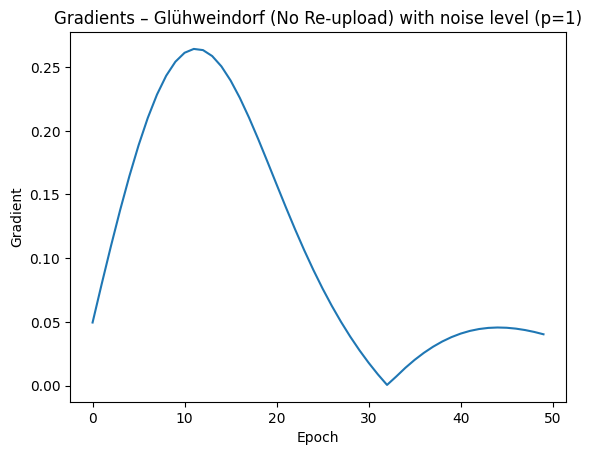

Train/Test accuracy: 0.7857142857142857 0.8266666666666667


In [ ]:
X_train, X_test, y_train, y_test = load_dataset("gluehweindorf.csv")

y_train_pm = 2 * y_train - 1   # {0,1} → {-1,+1}
noise = [0, 0.1, 0.25, 0.5, 0.75, 1]
for p_noise in noise:
  print(f"Gluehweindorf for noise p = {p_noise}")
  w_g, loss_g, grad_g, circ_g = train_vqc_with_shadows(
      X_train, y_train_pm,
      entangle=True,
      stepsize=0.1,
      epochs=50,
      p_noise=p_noise
  )
  plt.plot(loss_g)
  plt.title(f"Training Loss – Glühweindorf (No Re-upload) with noise level (p={p_noise})")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.show()
  plt.plot(grad_g)
  plt.title(f"Gradients – Glühweindorf (No Re-upload) with noise level (p={p_noise})")
  plt.xlabel("Epoch")
  plt.ylabel("Gradient")
  plt.show()

  print("Train/Test accuracy:",
        evaluate(circ_g, w_g, X_train, y_train)[0],
        evaluate(circ_g, w_g, X_test, y_test)[0])


The training loss for the baseline model on the Glühweindorf dataset is the lowest for the lowest noise level (p=0.0). The present of noise also does not seem to have a significant effect on the convergence

## Lebkuchenstadt (baseline)



100%|██████████| 60/60 [08:24<00:00,  8.42s/it]


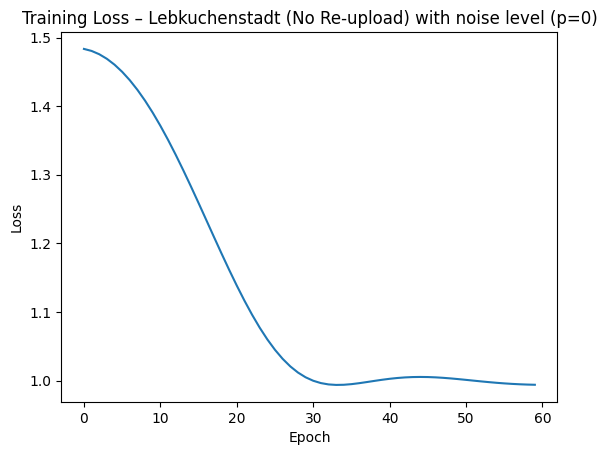

Train/Test accuracy: 0.5457142857142857 0.37333333333333335


100%|██████████| 60/60 [08:14<00:00,  8.24s/it]


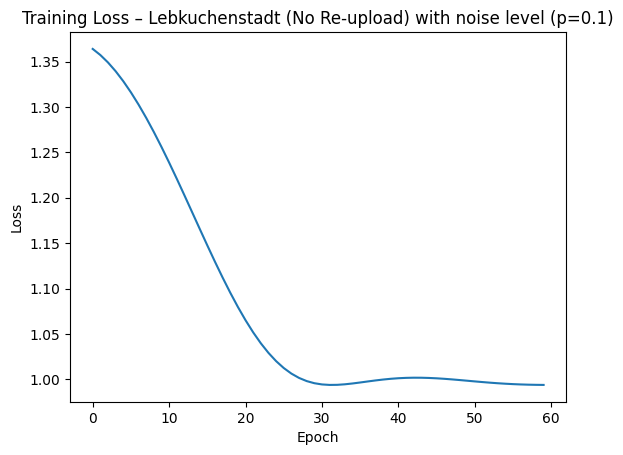

Train/Test accuracy: 0.5314285714285715 0.41333333333333333


100%|██████████| 60/60 [08:15<00:00,  8.26s/it]


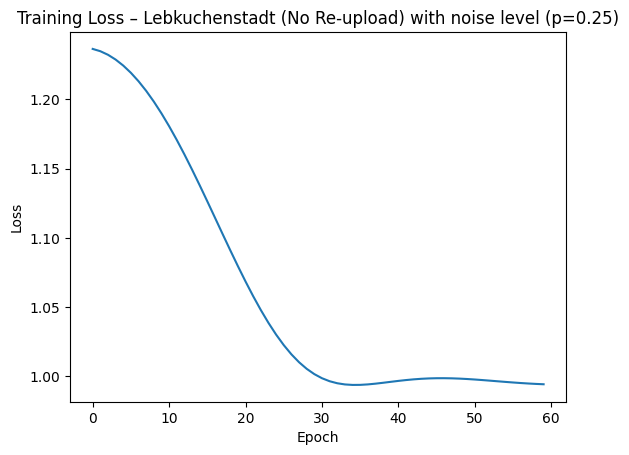

Train/Test accuracy: 0.5257142857142857 0.4533333333333333


100%|██████████| 60/60 [08:00<00:00,  8.00s/it]


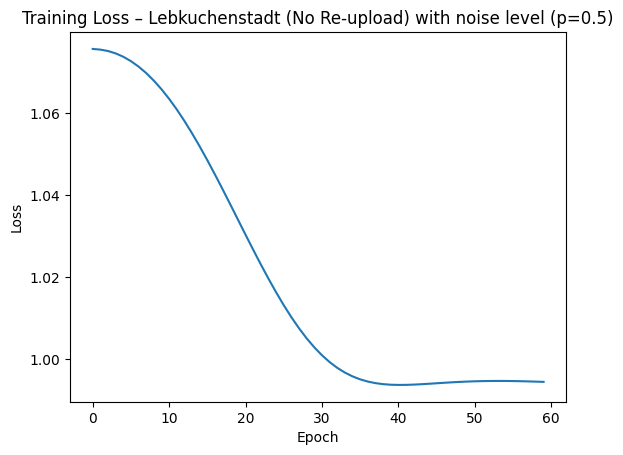

Train/Test accuracy: 0.5285714285714286 0.4266666666666667


100%|██████████| 60/60 [08:06<00:00,  8.11s/it]


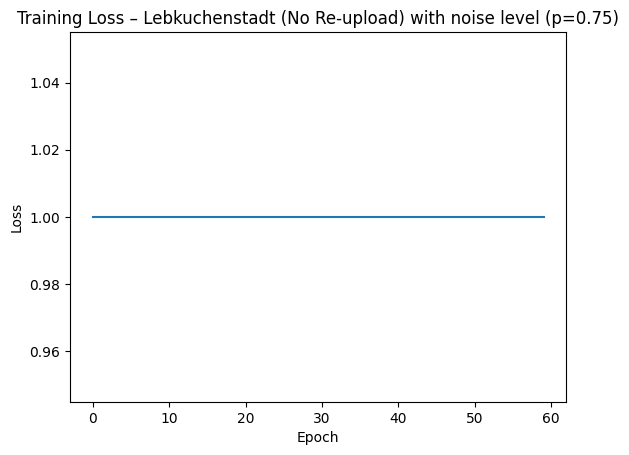

Train/Test accuracy: 0.5057142857142857 0.56


100%|██████████| 60/60 [08:25<00:00,  8.42s/it]


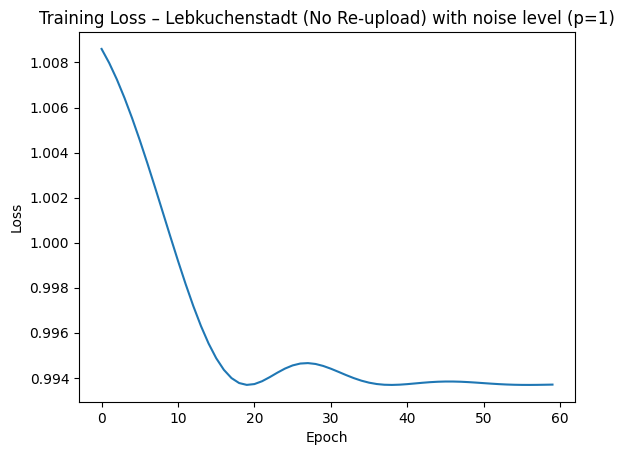

Train/Test accuracy: 0.5342857142857143 0.4266666666666667


In [ ]:
X_train, X_test, y_train, y_test = load_dataset("lebkuchenstadt.csv")

y_train_pm = 2 * y_train - 1   # {0,1} → {-1,+1}
y_test_pm  = 2 * y_test - 1

noise = [0, 0.1, 0.25, 0.5, 0.75, 1]
for p_noise in noise:
  w_l, loss_l, grad_l, circ_l = train_vqc_with_shadows(
      X_train, y_train_pm,
      entangle=True,
      stepsize=0.05,
      epochs=60,
      p_noise=p_noise
  )

  plt.plot(loss_l)
  plt.title(f"Training Loss – Lebkuchenstadt (No Re-upload) with noise level (p={p_noise})")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.show()

  print("Train/Test accuracy:",
        evaluate(circ_l, w_l, X_train, y_train)[0],
        evaluate(circ_l, w_l, X_test, y_test)[0])

## Krampuskogel (baseline)



100%|██████████| 80/80 [11:01<00:00,  8.26s/it]


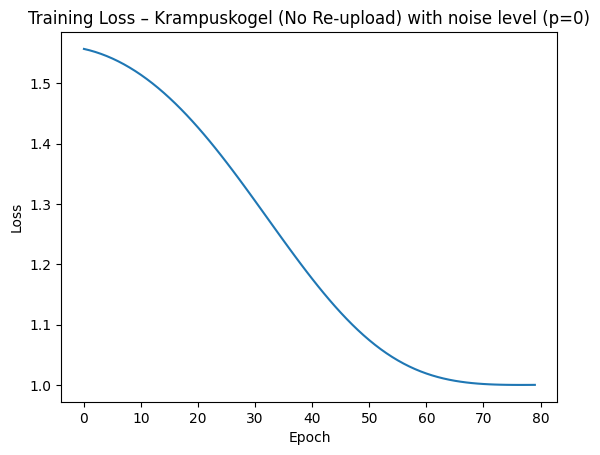

Train/Test accuracy: 0.5057142857142857 0.5


100%|██████████| 80/80 [10:42<00:00,  8.03s/it]


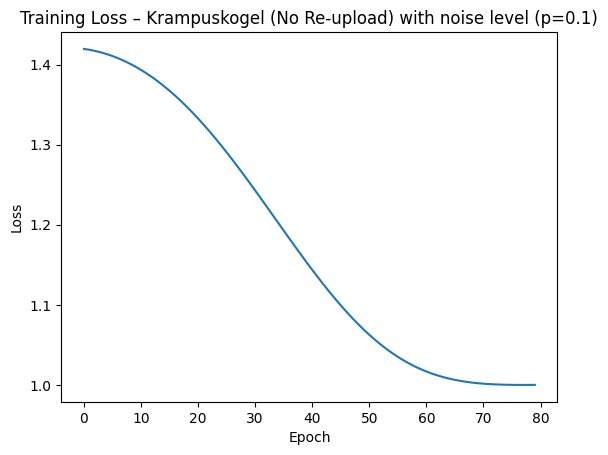

Train/Test accuracy: 0.49714285714285716 0.5466666666666666


100%|██████████| 80/80 [10:33<00:00,  7.92s/it]


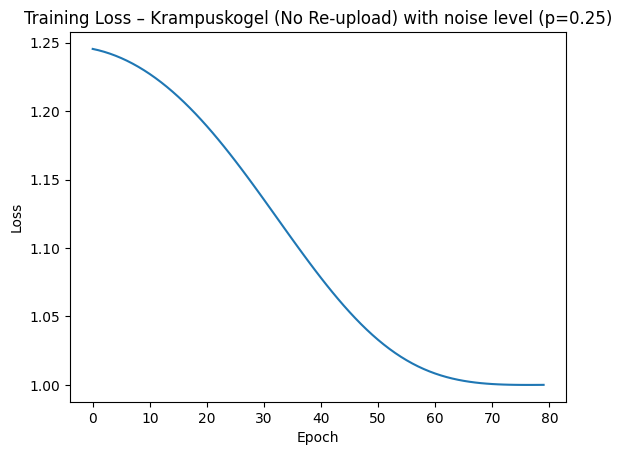

Train/Test accuracy: 0.5114285714285715 0.44666666666666666


100%|██████████| 80/80 [10:26<00:00,  7.83s/it]


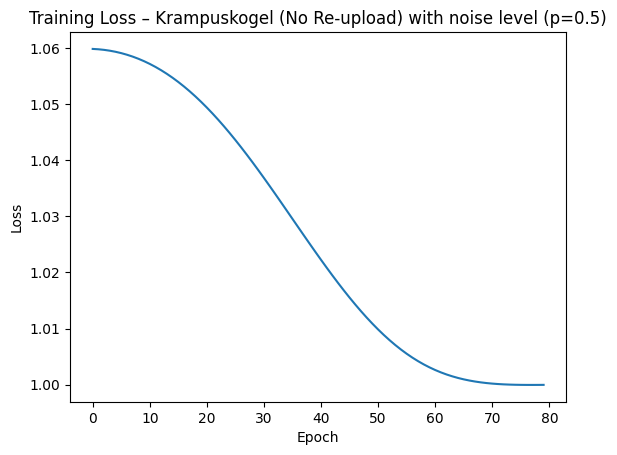

Train/Test accuracy: 0.5171428571428571 0.49333333333333335


100%|██████████| 80/80 [10:32<00:00,  7.91s/it]


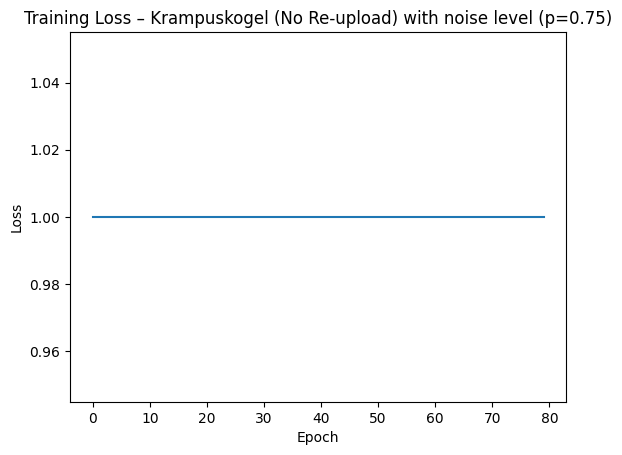

Train/Test accuracy: 0.4828571428571429 0.5466666666666666


100%|██████████| 80/80 [10:44<00:00,  8.06s/it]


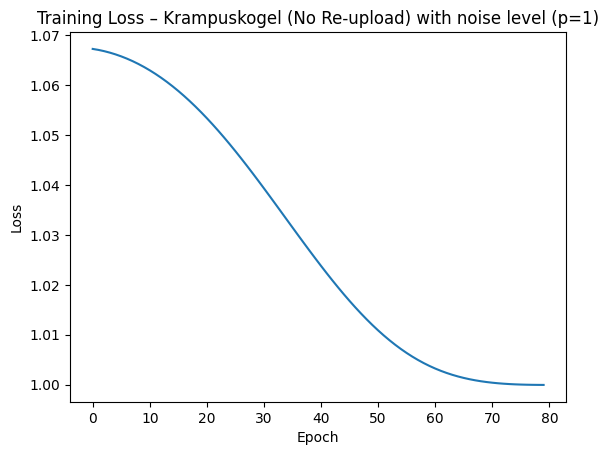

Train/Test accuracy: 0.5142857142857142 0.4666666666666667


In [ ]:
X_train, X_test, y_train, y_test = load_dataset("krampuskogel.csv")

y_train_pm = 2 * y_train - 1   # {0,1} → {-1,+1}
y_test_pm  = 2 * y_test - 1

noise = [0, 0.1, 0.25, 0.5, 0.75, 1]
for p_noise in noise:
  w_k, loss_k, grad_k, circ_k = train_vqc_with_shadows(
      X_train, y_train_pm,
      entangle=True,
      stepsize=0.02,
      epochs=80,
      p_noise=p_noise
  )

  plt.plot(loss_k)
  plt.title(f"Training Loss – Krampuskogel (No Re-upload) with noise level (p={p_noise})")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.show()

  print("Train/Test accuracy:",
        evaluate(circ_k, w_k, X_train, y_train)[0],
        evaluate(circ_k, w_k, X_test, y_test)[0])

**Noise observation**
An intersting observation that can be done in the noise values for the different data sets is that p=0.75 seems to be a special value for the data training process. For this value, the output continuously seems to be very close to 0. Since the labels that are use are {-1, 1}, the square loss will continously be 1.

**Loss curve**

When comparing the effect that the noise has on the training process for the three different datasets, we can do an interesting observation.

For Glühweindorf, the training process is heavily influenced by the training process. However, the more messy the dataset gets the less the noise seems to effect the loss curve of the the training process.  

**Accuracy**

For accuracy, we observed that applying noise does improve the accuracy on the data set. This can be observed on all three data sets.

**Convergence**

The Glühweindorf dataset seems to get negatively influenced on terms of convergence for higher levels of noise. Also, the higher the noise level, the higher the loss value that it converges on.

For Lebkuchenstadt, we can see that up untill noise level 0.5, the training processes converge in a similar way. However, for noise level 1, the process of convergence starts earlier and at a lower value.

For Krampuskogel, the convergence does not seem to get influenced by the noise.

**Conclusion**
We can conclude that the messier the dataset, the less the training process is affected by noise.

# DATA RE-UPLOADING

## VQC WITH data re-uploading

For this implementation of the `train_vqc_reupload_shadow`, we adjusted the `train_vqc_reupload` function from task one in a similar way as we did for for the baseline training process.

This means:
- We added noise in the original circuit
- We added an extra circuit that returns shadows

In [ ]:
def train_vqc_reupload_shadow(
    X_train, y_train,
    n_layers=3,
    entangle=True,
    n_qubits=2,
    stepsize=0.05,
    epochs=60,
    p_noise=0.1
):
    # Create a quantum device with the specified number of qubits
    dev = qml.device("default.mixed", wires=n_qubits)

    # Encode classical input features into quantum rotations
    def encode(x):
        for i in range(n_qubits):
            qml.RX(x[i], wires=i)

    # Variational layer with trainable parameters and optional entanglement
    def variational_layer(weights):
        # Apply parameterized rotations on each qubit
        for i in range(n_qubits):
            qml.RY(weights[i], wires=i)
        # Apply entangling gate if enabled
        if entangle:
            qml.CNOT(wires=[0, 1])
            qml.CNOT(wires=[1, 0])

    # Define the quantum circuit with data re-uploading
    @qml.qnode(dev)
    def circuit(x, weights):
        # Repeatedly encode the same data and apply variational layers
        for l in range(n_layers):
            encode(x)  # Data re-uploading step
            variational_layer(weights[l])
            for w in range(n_qubits):
              qml.DepolarizingChannel(p_noise, wires=w)
        # Measure expectation value for binary classification
        return qml.expval(qml.PauliZ(0))

    # Define the classical shadow quantum circuit as a PennyLane QNode
    @qml.qnode(dev)
    def shadow_circuit(x, weights):
        for l in range(n_layers):
            encode(x)  # Data re-uploading step
            variational_layer(weights[l])
            for w in range(n_qubits):
              qml.DepolarizingChannel(p_noise, wires=w)
        return qml.classical_shadow(wires=range(n_qubits))

    # Loss function (mean squared error)
    # Uses continuous outputs for differentiability
    def loss(weights):
      preds = [circuit(x, weights) for x in X_train]
      return pnp.mean((pnp.array(preds) - y_train) ** 2)


    # Initialize trainable parameters for all re-upload layers
    weights = pnp.random.normal(0, 0.1, size=(n_layers, n_qubits), requires_grad=True)
    # Adam optimizer for training
    opt = qml.AdamOptimizer(stepsize=stepsize)

    # Store loss values for each training epoch
    losses = []
    for _ in tqdm.tqdm(range(epochs)):
        weights, current_loss = opt.step_and_cost(loss, weights)
        losses.append(current_loss)

    return weights, losses, shadow_circuit

## Glühweindorf WITH re-upload

For the Glühweindorf dataset, the re-uploading variational quantum classifier uses the same configuration as the baseline model in terms of qubit count, entanglement strategy, optimizer, learning rate, and number of training epochs. The only difference is the application of data re-uploading, where the input data is encoded three times using three consecutive variational layers.

100%|██████████| 50/50 [08:58<00:00, 10.76s/it]


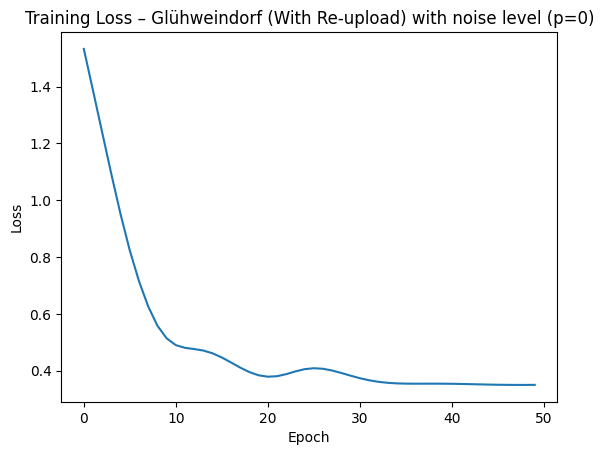

Train accuracy (re-upload): 0.9114285714285715
Test accuracy  (re-upload): 0.8666666666666667


100%|██████████| 50/50 [08:54<00:00, 10.69s/it]


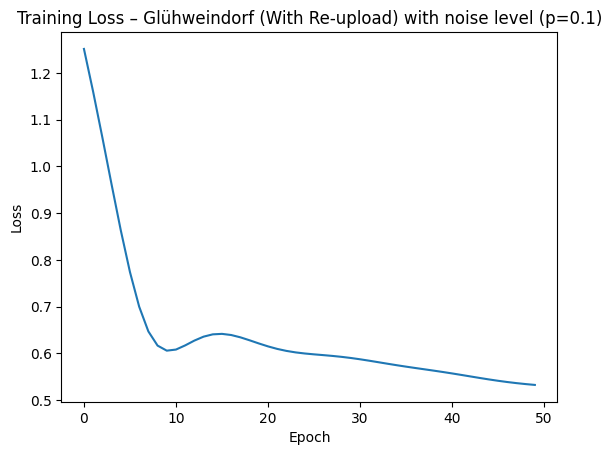

Train accuracy (re-upload): 0.92
Test accuracy  (re-upload): 0.8866666666666667


100%|██████████| 50/50 [09:01<00:00, 10.83s/it]


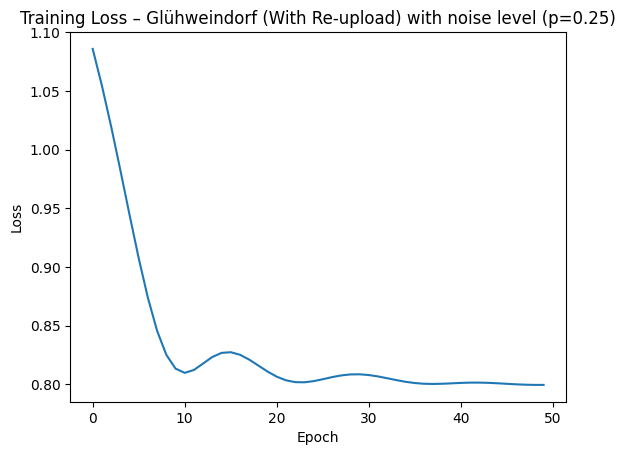

Train accuracy (re-upload): 0.8428571428571429
Test accuracy  (re-upload): 0.8


100%|██████████| 50/50 [08:56<00:00, 10.72s/it]


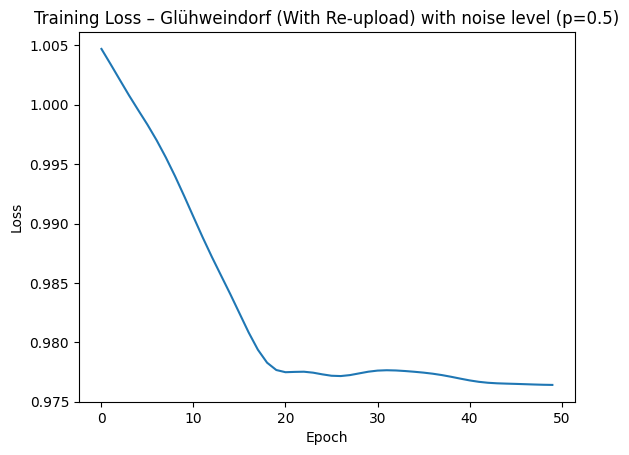

Train accuracy (re-upload): 0.66
Test accuracy  (re-upload): 0.7066666666666667


100%|██████████| 50/50 [08:55<00:00, 10.72s/it]


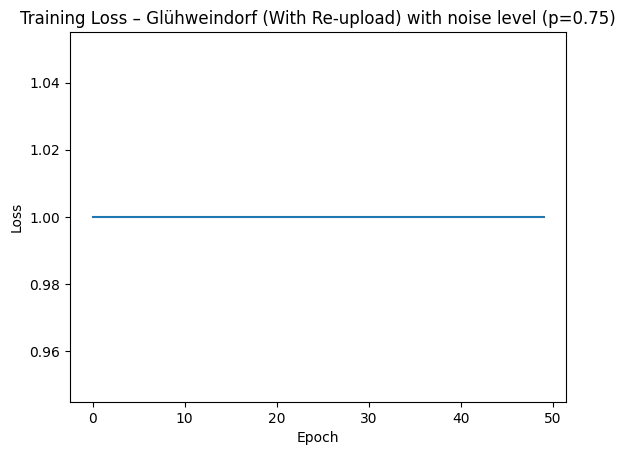

Train accuracy (re-upload): 0.4828571428571429
Test accuracy  (re-upload): 0.5


100%|██████████| 50/50 [09:10<00:00, 11.01s/it]


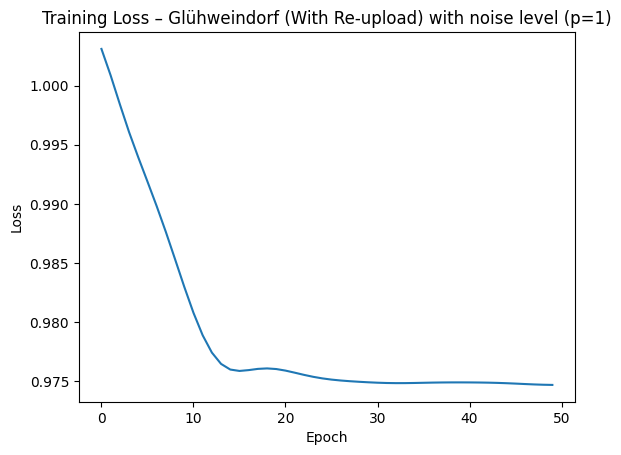

Train accuracy (re-upload): 0.64
Test accuracy  (re-upload): 0.6533333333333333


In [ ]:
X_train, X_test, y_train, y_test = load_dataset("gluehweindorf.csv")

y_train_pm = 2 * y_train - 1   # {0,1} → {-1,+1}
y_test_pm  = 2 * y_test - 1

noise = [0,0.1, 0.25, 0.5, 0.75, 1]

for p_noise in noise:
  w_gr, loss_gr, circ_gr = train_vqc_reupload_shadow(
      X_train, y_train_pm,
      n_layers=3,
      entangle=True,
      stepsize=0.1,
      epochs=50,
      p_noise=p_noise
  )

  plt.plot(loss_gr)
  plt.title(f"Training Loss – Glühweindorf (With Re-upload) with noise level (p={p_noise})")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.show()

  train_acc_r, train_cm_r = evaluate(circ_gr, w_gr, X_train, y_train)
  test_acc_r, test_cm_r   = evaluate(circ_gr, w_gr, X_test, y_test)

  print("Train accuracy (re-upload):", train_acc_r)
  print("Test accuracy  (re-upload):", test_acc_r)

## Lebkuchenstadt WITH re-upload



100%|██████████| 60/60 [11:06<00:00, 11.10s/it]


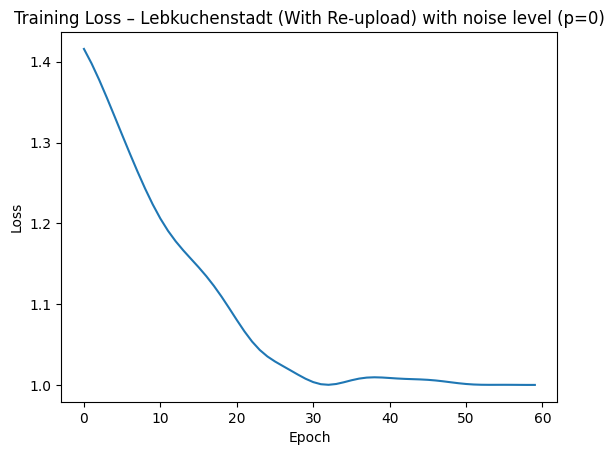

Train accuracy (re-upload): 0.4857142857142857
Test accuracy  (re-upload): 0.43333333333333335


100%|██████████| 60/60 [11:08<00:00, 11.14s/it]


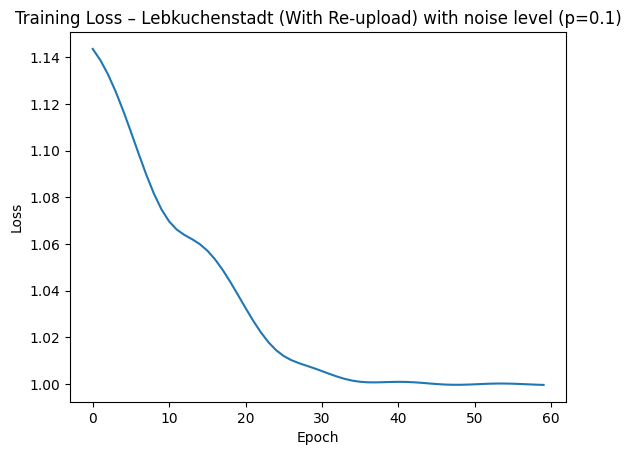

Train accuracy (re-upload): 0.5057142857142857
Test accuracy  (re-upload): 0.49333333333333335


100%|██████████| 60/60 [11:24<00:00, 11.40s/it]


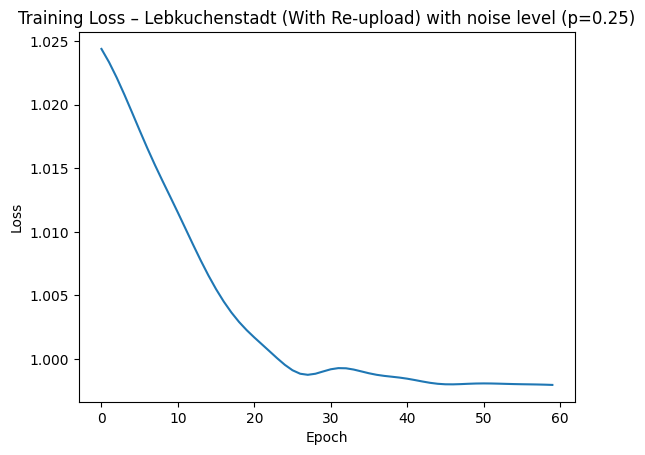

Train accuracy (re-upload): 0.5428571428571428
Test accuracy  (re-upload): 0.4666666666666667


100%|██████████| 60/60 [11:16<00:00, 11.27s/it]


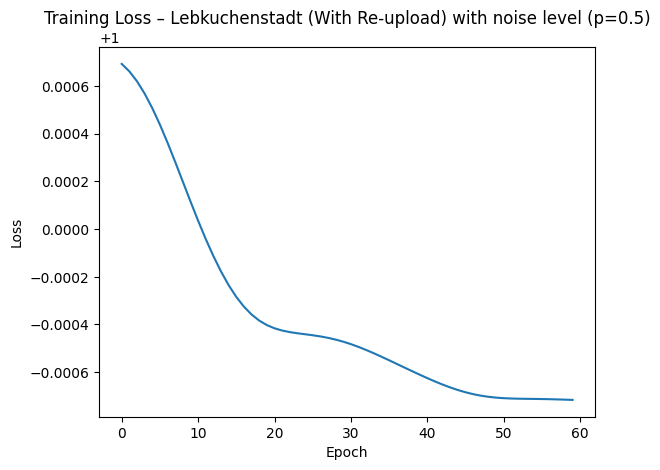

Train accuracy (re-upload): 0.4742857142857143
Test accuracy  (re-upload): 0.5


100%|██████████| 60/60 [11:38<00:00, 11.64s/it]


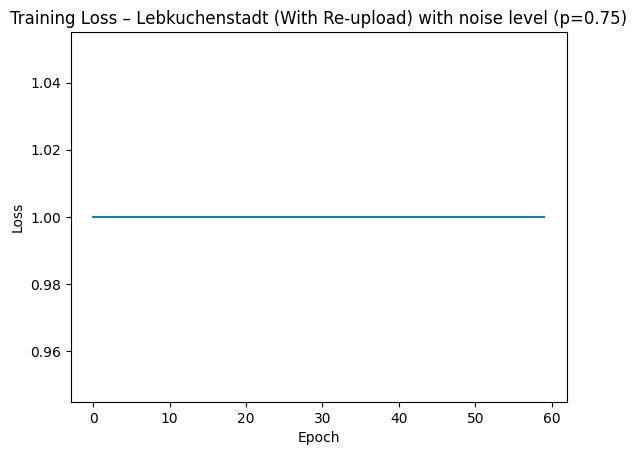

Train accuracy (re-upload): 0.5171428571428571
Test accuracy  (re-upload): 0.5533333333333333


100%|██████████| 60/60 [11:38<00:00, 11.64s/it]


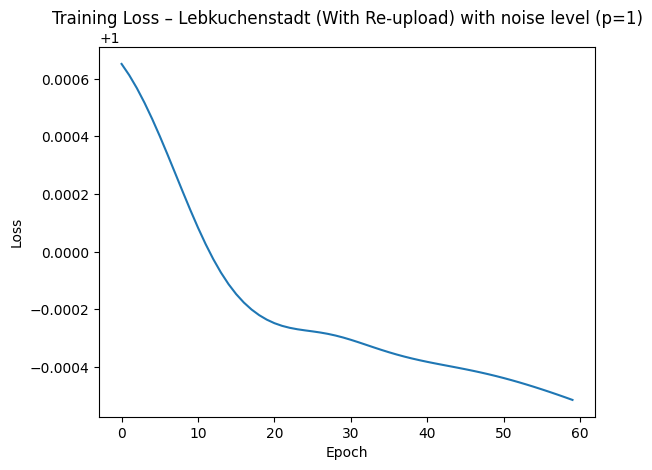

Train accuracy (re-upload): 0.5057142857142857
Test accuracy  (re-upload): 0.5133333333333333


In [ ]:
X_train, X_test, y_train, y_test = load_dataset("lebkuchenstadt.csv")

y_train_pm = 2 * y_train - 1   # {0,1} → {-1,+1}
y_test_pm  = 2 * y_test - 1
noise = [0,0.1, 0.25, 0.5, 0.75, 1]
for p_noise in noise:
  w_gr, loss_gr, circ_gr = train_vqc_reupload_shadow(
      X_train, y_train_pm,
      n_layers=3,
      entangle=True,
      stepsize=0.05,
      epochs=60,
      p_noise=p_noise
  )

  plt.plot(loss_gr)
  plt.title(f"Training Loss – Lebkuchenstadt (With Re-upload) with noise level (p={p_noise})")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.show()

  train_acc_r, train_cm_r = evaluate(circ_gr, w_gr, X_train, y_train)
  test_acc_r, test_cm_r   = evaluate(circ_gr, w_gr, X_test, y_test)

  print("Train accuracy (re-upload):", train_acc_r)
  print("Test accuracy  (re-upload):", test_acc_r)

## Krampuskogel WITH re-upload



100%|██████████| 80/80 [14:48<00:00, 11.11s/it]


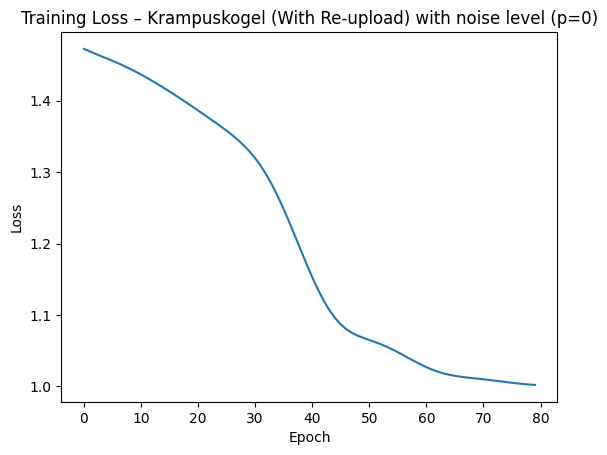

Train accuracy (re-upload): 0.4942857142857143
Test accuracy  (re-upload): 0.46


100%|██████████| 80/80 [14:40<00:00, 11.01s/it]


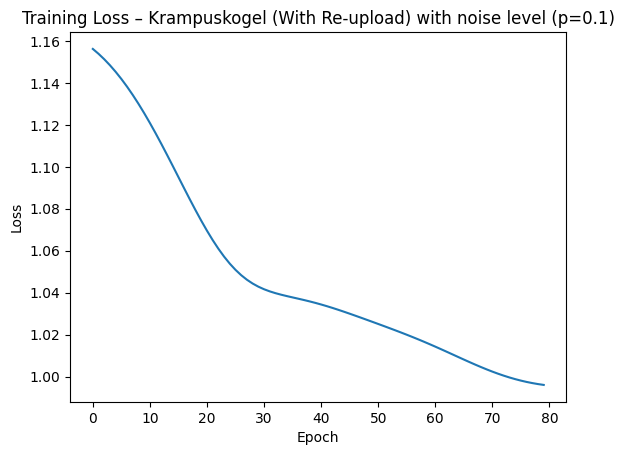

Train accuracy (re-upload): 0.5257142857142857
Test accuracy  (re-upload): 0.44666666666666666


100%|██████████| 80/80 [14:40<00:00, 11.01s/it]


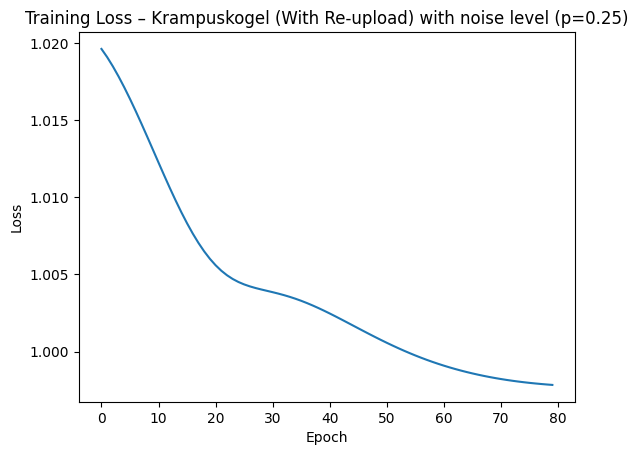

Train accuracy (re-upload): 0.5371428571428571
Test accuracy  (re-upload): 0.47333333333333333


100%|██████████| 80/80 [14:41<00:00, 11.01s/it]


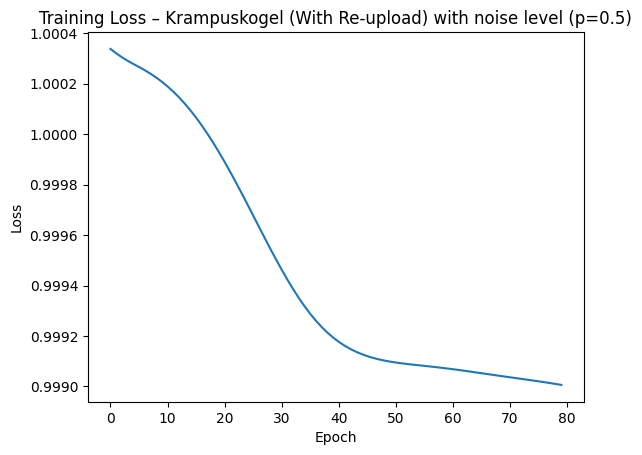

Train accuracy (re-upload): 0.5571428571428572
Test accuracy  (re-upload): 0.48


100%|██████████| 80/80 [14:28<00:00, 10.85s/it]


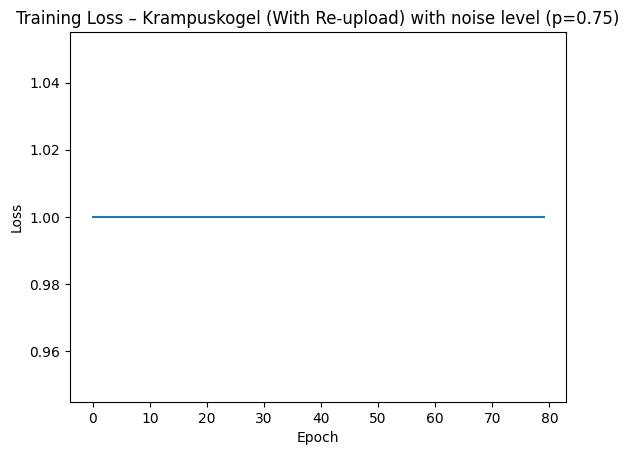

Train accuracy (re-upload): 0.4742857142857143
Test accuracy  (re-upload): 0.5133333333333333


100%|██████████| 80/80 [14:28<00:00, 10.86s/it]


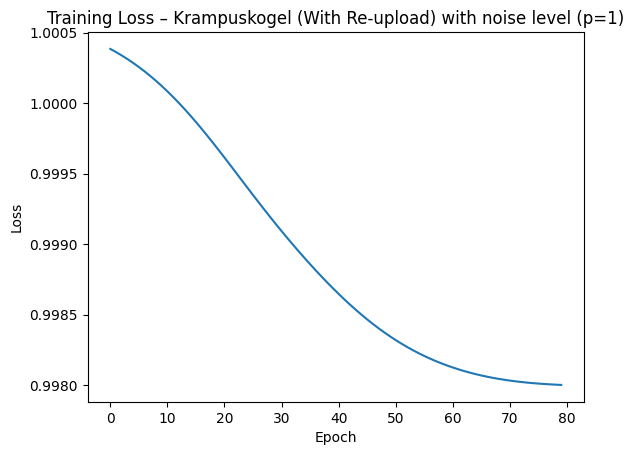

Train accuracy (re-upload): 0.52
Test accuracy  (re-upload): 0.4266666666666667


In [ ]:
X_train, X_test, y_train, y_test = load_dataset("krampuskogel.csv")

y_train_pm = 2 * y_train - 1   # {0,1} → {-1,+1}
y_test_pm  = 2 * y_test - 1

noise = [0,0.1, 0.25, 0.5, 0.75, 1]

for p_noise in noise:
  w_gr, loss_gr, circ_gr = train_vqc_reupload_shadow(
      X_train, y_train_pm,
      n_layers=3,
      entangle=True,
      stepsize=0.02,
      epochs=80,
      p_noise=p_noise
  )

  plt.plot(loss_gr)
  plt.title(f"Training Loss – Krampuskogel (With Re-upload) with noise level (p={p_noise})")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.show()

  train_acc_r, train_cm_r = evaluate(circ_gr, w_gr, X_train, y_train)
  test_acc_r, test_cm_r   = evaluate(circ_gr, w_gr, X_test, y_test)

  print("Train accuracy (re-upload):", train_acc_r)
  print("Test accuracy  (re-upload):", test_acc_r)

# Discussion

For **Glühweindorf**, the baseline classifier seems to get heavily impacted by the noise meaning that the loss converges at a lower value. However, for a low level of noise, the model does show a higher performance on accuracy. When data re-uploading is applied we can see that the noise levels move towards convergence in a similar way. However, the noise level heavily impacts the value of loss it converges on. For this dataset, the accuracy is also heavily impacted by the noise.

The **Lebkuchenstadt** dataset is more challenging due to systematic noise and class overlap. Therefore, the noise seems to affect this data set less compared to Glühweindorf. For the baseline classifier, we can observe that although the convergence and loss are influenced in a similar way to the Glühweindorf it is in a subdued manner. When we apply data re-uploading we see that the accuracy seems to improve with noise. Also, where the baseline classifier had small differences in the loss curve. The differences in this curve seem to be more significantly. The loss value drops fast for higher levels of noise.

**Krampuskogel** is the most difficult dataset. This is because it already is a messy dataset from itself. Therefore, we also observe that the noise does not really affect this dataset. For the baseline model we do not see any difference between the different levels of noise. For the data re-uploading classifier, we see that the noise does affect the loss curve. It also seems that higher noise lowers the value of loss it converges on. And although the accuracy seems best for a higher level of noise, it still only performs slightly above chance.

Overall, our results show that the effect that noise has on the classifier highly relies on the data set itself. We can conclude that a messy dataset is less affected by noise than a clean data set.
